# 1 Author

**Student Name**:  Yuchen Fan

**Student ID**:  210977729


# 2 Problem formulation

**1. Conducting unsupervised learning to classify whether smiling or not**

Since there are not many well-annotated data, most of our machine learning work will focus on unannotated data. Therefore, we need to do unsupervised learning. I want to find out the results and ways to improve the performance.

**2. Conducting semi-supervised learning to classify whether smiling or not**

To provide some data points as guideline for unsupervised learning, we need manually or make use of SOTA models to annotate. That is semi-supervised learning. I want to get familiar with the pipeline and find out to what extent will semi-supervied learning improve the performance.



# 3 Machine Learning pipeline

The pipeline is:

Load data -> Preprocess data -> Transform data -> Unsupervised learning or semi-supervised learning -> evaluate the results.

For **Load data:**

Input is file path, output is an array containing all the images and labels.

For **Preprocess data and Transform data:**

Input is an image array, output is a feature matrix generated by ResNet50. Its dimension is reduced by using PCA.

For **Unsupervised learning or semi-supervised learning:**

Input is a feature matrix, output is a classifier.

# 4 Transformation stage

For a picture, what matters is the order of the pixeds and the value of each pixel. In my procession, I normalize the values of pixels to 0 - 1 and randomly drop some pixels.

By using transformation, the effectiveness and robustness of the model will be improved a lot, overfitting will be avoided.

The implementation are as follows

In [54]:
from torchvision.transforms import transforms

from PIL import Image
def preprocess_image(image):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image.astype('uint8'))

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image).unsqueeze(0)
    return image

What's more, to progress in unsupervised learning or semi-supervised learning, we should identify and understand the underlying structure of the dataset, requring us to extract features.

There are many ways to extract features, for instance, using the original pixels, normalization and so on. The most effective way is using a pre-trained model because of its ability to do understream works withou fine-tuning. Besides, it gets acess to thousands of data, thus better for feature extraction.

Below are my implementation:

In [55]:
import torch
import numpy as np
def feature_extraction(model,dataset):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    all_features = []
    for image, label in dataset:
        image = preprocess_image(image).to(device)
        with torch.no_grad():
            features = model(image)
            features_np = features.squeeze().cpu().numpy()
            all_features.append(features_np)

    all_features_np = np.array(all_features)
    return all_features_np


# 5 Modelling

In this section, based on the results in miniProject_basic, I decide to use the best-performing model, e.g. ResNet50 to extract features.
Since in the basic funtion, it achieves the highest accuracy score in the process of supervised learning, I assume that based on the residual connection and pretraining process, it should be good for feature extraction.


In [73]:
import torch.nn as nn
import torch
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 56 * 56, 128) 
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [74]:
from torchvision import models
import torch

resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1])) 
resnet18 = models.resnet18(pretrained=True)
resnet18 = torch.nn.Sequential(*(list(resnet18.children())[:-1])) 
resnet34 = models.resnet34(pretrained=True)
resnet34 = torch.nn.Sequential(*(list(resnet34.children())[:-1]))
cnn = CNN(2)

c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weight

# 6 Methodology

For **Unsupervised Learning:**

Firstly I normalize all features to reduce calculation. Then I use K-means algorithm to make clusters. Finally, I use PCA plot and confusiton matrix along with clasification_report for assession.

The implementation is as follows:


In [57]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def flatten_images(X):
    return X.reshape(X.shape[0], -1)  # 将每个图像展平



def cluster_features_un(X_train_flat, y_train, X_val_flat, y_val, k=2):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(X_train_flat)

    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(features_scaled)

    # 在降维后的数据上进行可视化
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features_scaled)
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', marker='o')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.title('Cluster Visualization')
    plt.show()

    # 对验证集数据进行预测
    X_val_scaled = scaler.transform(X_val_flat)
    y_val_pred = kmeans.predict(X_val_scaled)

    # 评估模型
    print(confusion_matrix(y_val, y_val_pred))
    print(classification_report(y_val, y_val_pred))


For **Semi-supervised Learning:**

Firstly I use random library to find some guidance for unsupervised part. After that, I normalize all features to reduce calculation. Then I use K-means algorithm to make clusters. Finally, I use PCA plot and confusiton matrix along with clasification_report for assession.

The implementation is as follows:

In [58]:
from sklearn.cluster import KMeans
import numpy as np
from random import randint
from sklearn.metrics import confusion_matrix, classification_report


def cluster_features_semi(X_train, y_train, X_val, y_val, k=2, n=1000):
    cnt = 0
    labeled_indices = []
    while cnt < n:
        idx = randint(0, len(X_train)-1)
        if idx not in labeled_indices:
            labeled_indices.append(idx)
            cnt += 1
            
    scaler = StandardScaler()
    
    features_scaled = scaler.fit_transform(X_train)
            
    labeled_features = X_train[labeled_indices]
    labeled_labels = y_train[labeled_indices]

    unique_labels = np.unique(labeled_labels)
    initial_centers = [labeled_features[labeled_labels == label].mean(axis=0) for label in unique_labels]

    kmeans = KMeans(n_clusters=len(unique_labels), init=np.vstack(initial_centers), n_init=1)
    kmeans.fit(X_train)

    pca = PCA(n_components=k)
    reduced_features = pca.fit_transform(features_scaled)
    
    clusters = kmeans.predict(features_scaled)

    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', marker='o')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.title('Cluster Visualization')
    plt.show()
    
    y_val_pred = kmeans.predict(X_val)
    print(confusion_matrix(y_val, y_val_pred))
    print(classification_report(y_val, y_val_pred))

# 7 Dataset

At first, I read in the images and labels, making them a dataset.

Then as mentioned above, I did some preprocess, for instance, normalization, dropping pixels, flipping, ratation and so on.

In [59]:
'''
load dataset
'''

import cv2
import os
from sklearn.model_selection import train_test_split

def load_dataset(model):
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    root = 'C:\\Users\\yuche\\Desktop\\Mini_Project\\files'
    predictors = []

    classification_labels = []
    detection_labels = []
    with open('C:\\Users\\yuche\\Desktop\\Mini_Project\\labels.txt') as f:
        for line in f.readlines():
            classification_labels.append(int(line[0]))
            line = line[2:].split()
            detection_labels.append((float(line[0]), float(line[1]), float(line[2])))
            
    for i in range(len(detection_labels)):
        detection_label = detection_labels[i]
        classification_label = classification_labels[i]
        filename = f'{root}\\file{str(i+1).zfill(4)}.jpg'
        img = cv2.imread(filename)
        img = cv2.resize(img, (256, 256))
        predictors.append(img)

    classification_dataset = []
    for i in range(len(classification_labels)):
        classification_dataset.append((predictors[i], classification_labels[i]))
        
    detection_dataset = []
    for i in range(len(detection_labels)):
        detection_dataset.append((predictors[i], detection_labels[i]))

    all_features_np = feature_extraction(model, classification_dataset)
    all_labels = np.array(classification_labels)

    X_train, X_val, y_train, y_val = train_test_split(all_features_np, all_labels, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

    

# 8 Results

For **Unsupervised Learning:**


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


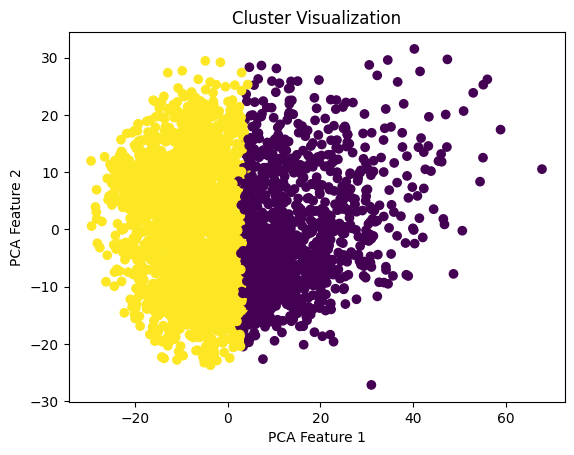

[[150 204]
 [124 322]]
              precision    recall  f1-score   support

           0       0.55      0.42      0.48       354
           1       0.61      0.72      0.66       446

    accuracy                           0.59       800
   macro avg       0.58      0.57      0.57       800
weighted avg       0.58      0.59      0.58       800



In [60]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_un(X_train_flat, y_train, X_val_flat, y_val, k=2)

c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


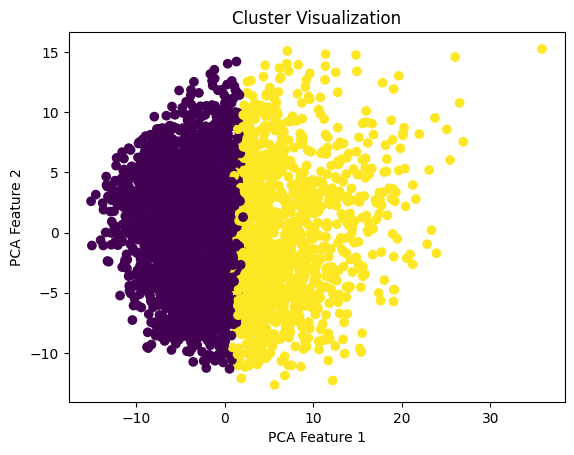

[[187 167]
 [323 123]]
              precision    recall  f1-score   support

           0       0.37      0.53      0.43       354
           1       0.42      0.28      0.33       446

    accuracy                           0.39       800
   macro avg       0.40      0.40      0.38       800
weighted avg       0.40      0.39      0.38       800



In [63]:
X_train, X_val, y_train, y_val = load_dataset(resnet34)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_un(X_train_flat, y_train, X_val_flat, y_val, k=2)

c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


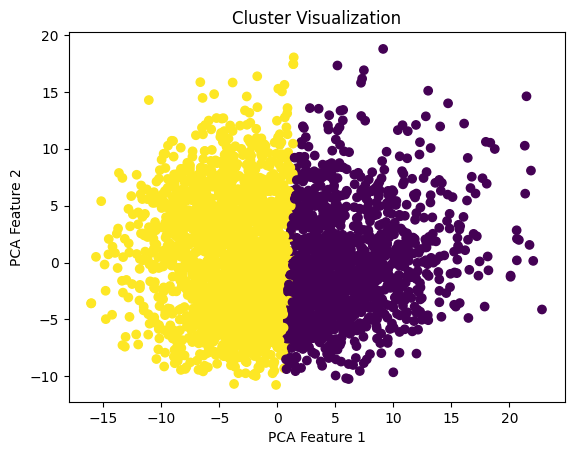

[[177 177]
 [139 307]]
              precision    recall  f1-score   support

           0       0.56      0.50      0.53       354
           1       0.63      0.69      0.66       446

    accuracy                           0.60       800
   macro avg       0.60      0.59      0.59       800
weighted avg       0.60      0.60      0.60       800



In [64]:
X_train, X_val, y_train, y_val = load_dataset(resnet18)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_un(X_train_flat, y_train, X_val_flat, y_val, k=2)

c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


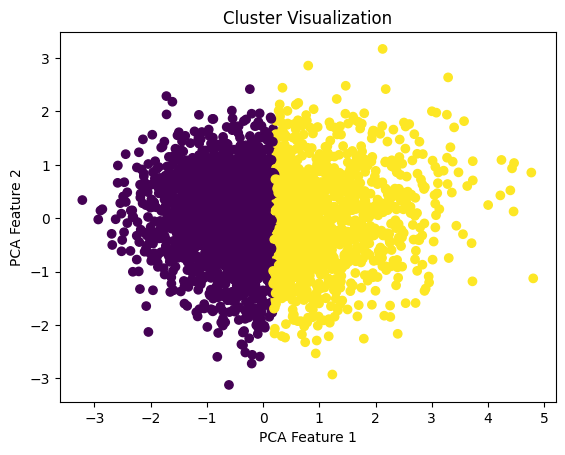

[[216 138]
 [268 178]]
              precision    recall  f1-score   support

           0       0.45      0.61      0.52       354
           1       0.56      0.40      0.47       446

    accuracy                           0.49       800
   macro avg       0.50      0.50      0.49       800
weighted avg       0.51      0.49      0.49       800



In [75]:
X_train, X_val, y_train, y_val = load_dataset(cnn)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_un(X_train_flat, y_train, X_val_flat, y_val, k=2)

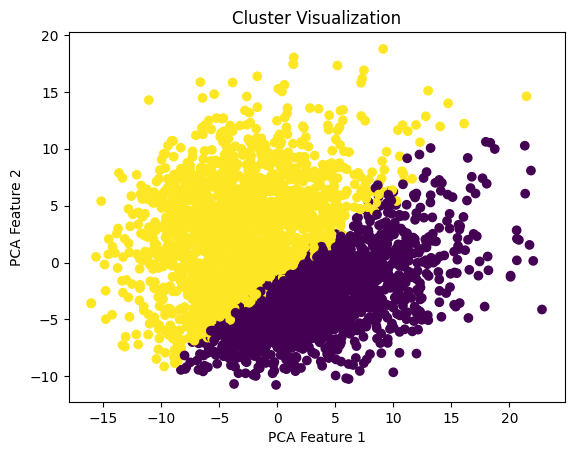

[[264  90]
 [216 230]]
              precision    recall  f1-score   support

           0       0.55      0.75      0.63       354
           1       0.72      0.52      0.60       446

    accuracy                           0.62       800
   macro avg       0.63      0.63      0.62       800
weighted avg       0.64      0.62      0.61       800



In [65]:
X_train, X_val, y_train, y_val = load_dataset(resnet18)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 200)

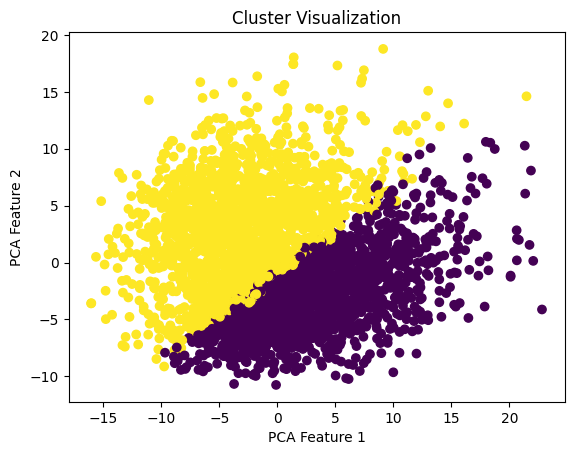

[[264  90]
 [213 233]]
              precision    recall  f1-score   support

           0       0.55      0.75      0.64       354
           1       0.72      0.52      0.61       446

    accuracy                           0.62       800
   macro avg       0.64      0.63      0.62       800
weighted avg       0.65      0.62      0.62       800



In [66]:
X_train, X_val, y_train, y_val = load_dataset(resnet18)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 500)

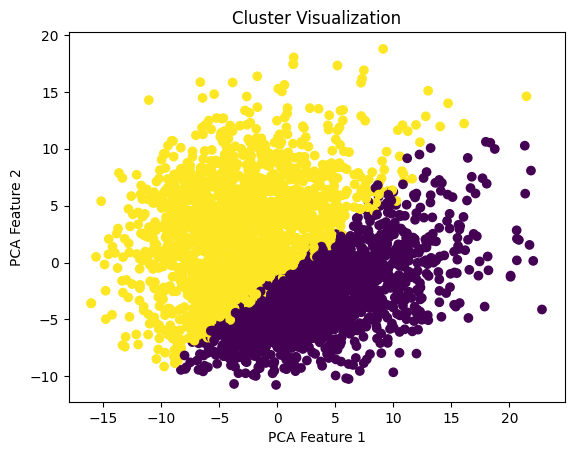

[[264  90]
 [216 230]]
              precision    recall  f1-score   support

           0       0.55      0.75      0.63       354
           1       0.72      0.52      0.60       446

    accuracy                           0.62       800
   macro avg       0.63      0.63      0.62       800
weighted avg       0.64      0.62      0.61       800



In [67]:
X_train, X_val, y_train, y_val = load_dataset(resnet18)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 1000)

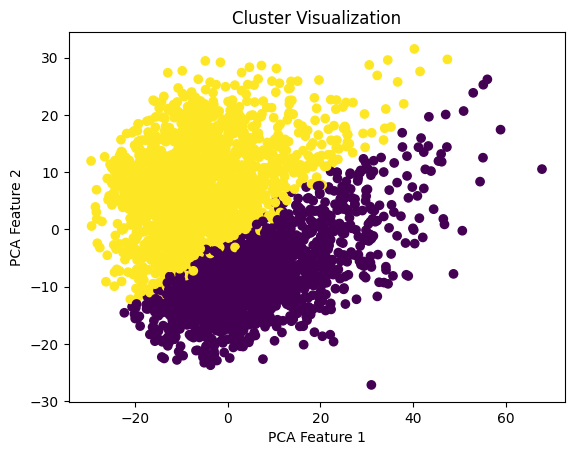

[[261  93]
 [197 249]]
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       354
           1       0.73      0.56      0.63       446

    accuracy                           0.64       800
   macro avg       0.65      0.65      0.64       800
weighted avg       0.66      0.64      0.64       800



In [70]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 200)

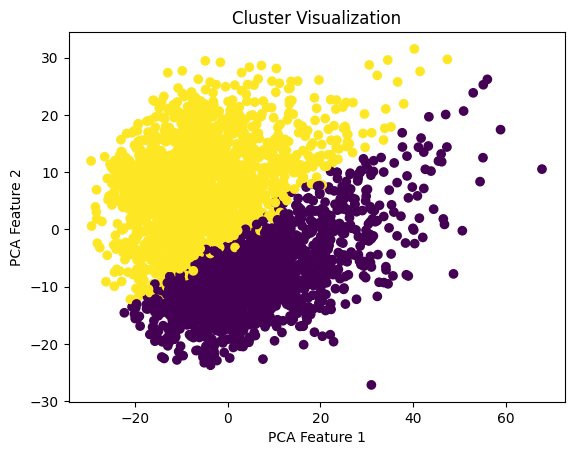

[[262  92]
 [197 249]]
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       354
           1       0.73      0.56      0.63       446

    accuracy                           0.64       800
   macro avg       0.65      0.65      0.64       800
weighted avg       0.66      0.64      0.64       800



In [71]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 500)

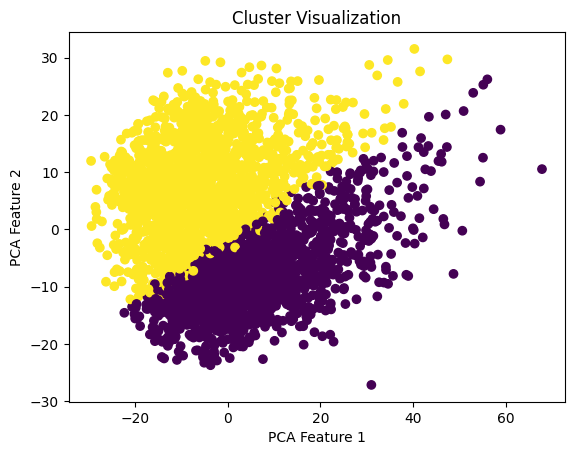

[[262  92]
 [197 249]]
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       354
           1       0.73      0.56      0.63       446

    accuracy                           0.64       800
   macro avg       0.65      0.65      0.64       800
weighted avg       0.66      0.64      0.64       800



In [72]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 1000)

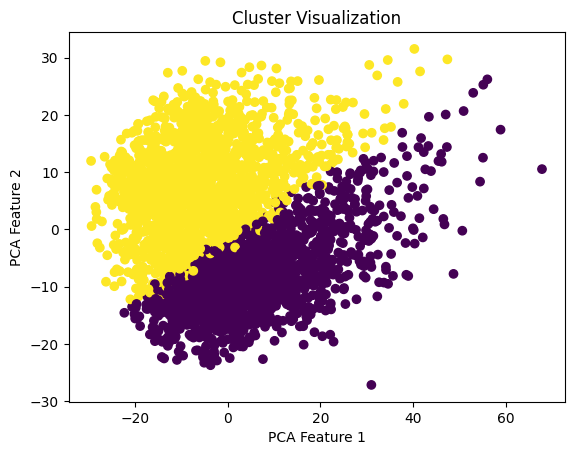

[[262  92]
 [197 249]]
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       354
           1       0.73      0.56      0.63       446

    accuracy                           0.64       800
   macro avg       0.65      0.65      0.64       800
weighted avg       0.66      0.64      0.64       800



In [78]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 200)

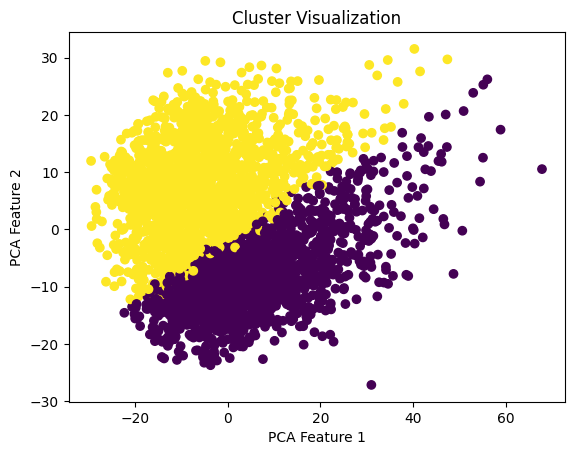

[[262  92]
 [197 249]]
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       354
           1       0.73      0.56      0.63       446

    accuracy                           0.64       800
   macro avg       0.65      0.65      0.64       800
weighted avg       0.66      0.64      0.64       800



In [77]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 500)

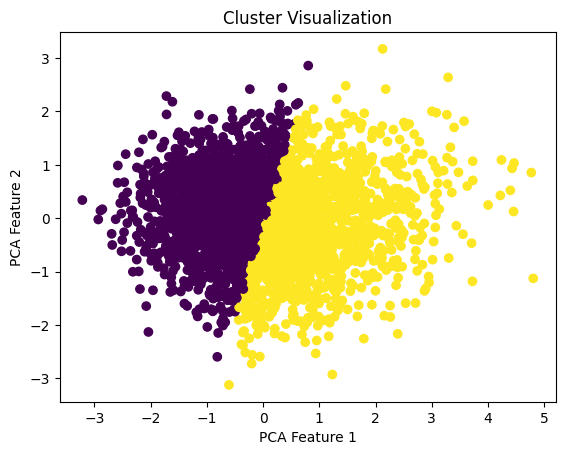

[[213 141]
 [267 179]]
              precision    recall  f1-score   support

           0       0.44      0.60      0.51       354
           1       0.56      0.40      0.47       446

    accuracy                           0.49       800
   macro avg       0.50      0.50      0.49       800
weighted avg       0.51      0.49      0.49       800



In [80]:
X_train, X_val, y_train, y_val = load_dataset(cnn)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 1000)

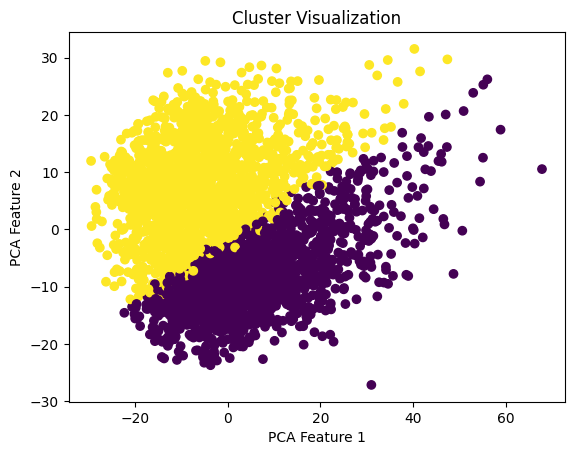

[[262  92]
 [197 249]]
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       354
           1       0.73      0.56      0.63       446

    accuracy                           0.64       800
   macro avg       0.65      0.65      0.64       800
weighted avg       0.66      0.64      0.64       800



In [79]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 2000)